# Deep Convolutional Q-Learning for Pac-Man

## Part 0 - Installing the required packages and importing the libraries

### Installing Gymnasium

In [1]:
!pip install gymnasium
!pip install "gymnasium[atari, accept-rom-license]"
!brew install swig
!pip install "gymnasium[box2d]"
%pip install torchvision

==> Auto-updating Homebrew...
Adjust how often this is run with HOMEBREW_AUTO_UPDATE_SECS or disable with
HOMEBREW_NO_AUTO_UPDATE. Hide these hints with HOMEBREW_NO_ENV_HINTS (see `man brew`).
^C

Note: you may need to restart the kernel to use updated packages.


### Importing the libraries

In [2]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
from torch.utils.data import DataLoader, TensorDataset

## Part 1 - Building the AI

### Creating the architecture of the Neural Network

In [5]:
class Network(nn.Module):

  def __init__(self, action_size, seed = 42):
    super(Network, self).__init__()
    self.seed = torch.manual_seed(seed)
    self.conv1 = nn.Conv2d(3, 32, kernel_size = 8, stride = 4)
    self.bn1 = nn.BatchNorm2d(32)
    self.conv2 = nn.Conv2d(32, 64, kernel_size = 4, stride = 2)
    self.bn2 = nn.BatchNorm2d(64)
    self.conv3 = nn.Conv2d(64, 64, kernel_size = 3, stride = 1)
    self.bn3 = nn.BatchNorm2d(64)
    self.conv4 = nn.Conv2d(64, 128, kernel_size = 3, stride = 1)
    self.bn4 = nn.BatchNorm2d(128)
    self.fc1 = nn.Linear(10 * 10 * 128, 512)
    self.fc2 = nn.Linear(512, 256)
    self.fc3 = nn.Linear(256, action_size)

  def forward(self, state):
    x = F.relu(self.bn1(self.conv1(state)))
    x = F.relu(self.bn2(self.conv2(x)))
    x = F.relu(self.bn3(self.conv3(x)))
    x = F.relu(self.bn4(self.conv4(x)))
    x = x.view(x.size(0), -1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    return self.fc3(x)

## Part 2 - Training the AI

### Setting up the environment

In [6]:
import gymnasium as gym
env_name = 'MsPacmanDeterministic-v0'
env = gym.make(env_name, full_action_space = False)
state_shape = env.observation_space.shape
state_size = env.observation_space.shape[0]
number_actions = env.action_space.n
print('State shape: ', state_shape)
print('State size: ', state_size)
print('Number of actions: ', number_actions)

State shape:  (210, 160, 3)
State size:  210
Number of actions:  9


/Users/harsh.rajput_awg/myspace/colab/venv/lib/python3.10/site-packages/gymnasium/envs/registration.py:513: DeprecationWarning: WARN: The environment MsPacmanDeterministic-v0 is out of date. You should consider upgrading to version `v4`.
  logger.deprecation(
A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


### Initializing the hyperparameters

In [8]:
learning_rate = 5e-4
minibatch_size = 100
discount_factor = 0.99
interpolation_parameter = 1e-3

### Preprocessing the frames

In [9]:
from PIL import Image
from torchvision import transforms

def preprocess_frame(frame):
  frame = Image.fromarray(frame)
  preprocess = transforms.Compose([transforms.Resize((128, 128)), transforms.ToTensor()])
  return preprocess(frame).unsqueeze(0)

## main logic

### Approach 1 - simple memory of list datatype

#### Implementing the DCQN class

In [12]:
high_reward_threshold = 10 # if reward > high_reward_threshold, then boost priority
high_priority_boost = 50 # boost value for high reward

class Agent():

  def __init__(self, action_size):
    # for cuda available devices
    # self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # for mac M1
    self.device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    self.action_size = action_size
    self.local_qnetwork = Network(action_size).to(self.device)
    self.target_qnetwork = Network(action_size).to(self.device)
    self.optimizer = optim.Adam(self.local_qnetwork.parameters(), lr = learning_rate)
    self.memory = deque(maxlen = 10000)
    self.t_step = 0

  def step(self, state, action, reward, next_state, done):
    state = preprocess_frame(state)
    next_state = preprocess_frame(next_state)
    self.memory.append((state, action, reward, next_state, done))
    if len(self.memory) > minibatch_size:
      experiences = random.sample(self.memory, k = minibatch_size)
      self.learn(experiences, discount_factor)

  def act(self, state, epsilon = 0.):
    state = preprocess_frame(state).to(self.device)
    self.local_qnetwork.eval()
    with torch.no_grad():
      action_values = self.local_qnetwork(state)
    self.local_qnetwork.train()
    if random.random() > epsilon:
      return np.argmax(action_values.cpu().data.numpy())
    else:
      return random.choice(np.arange(self.action_size))

  def learn(self, experiences, discount_factor):
    states, actions, rewards, next_states, dones = zip(*experiences)
    states = torch.from_numpy(np.vstack(states)).float().to(self.device)
    actions = torch.from_numpy(np.vstack(actions)).long().to(self.device)
    rewards = torch.from_numpy(np.vstack(rewards)).float().to(self.device)
    next_states = torch.from_numpy(np.vstack(next_states)).float().to(self.device)
    dones = torch.from_numpy(np.vstack(dones).astype(np.uint8)).float().to(self.device)
    next_q_targets = self.target_qnetwork(next_states).detach().max(1)[0].unsqueeze(1)
    q_targets = rewards + discount_factor * next_q_targets * (1 - dones)
    q_expected = self.local_qnetwork(states).gather(1, actions)
    loss = F.mse_loss(q_expected, q_targets)
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()
    self.soft_update(self.local_qnetwork, self.target_qnetwork, interpolation_parameter)
  
  def soft_update(self, local_model, target_model, interpolation_parameter):
    for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
      target_param.data.copy_(interpolation_parameter * local_param.data + (1.0 - interpolation_parameter) * target_param.data)

#### Initializing the DCQN agent

In [13]:
agent = Agent(number_actions)

#### Training the DCQN agent

In [16]:
from datetime import datetime
import time

minimum_score_required = 700
starting_episode = 1
number_episodes = 2000
maximum_number_timesteps_per_episode = 10000
epsilon_starting_value  = 1.0
epsilon_ending_value  = 0.01
epsilon_decay_value  = 0.995
epsilon = epsilon_starting_value
scores_on_100_episodes = deque(maxlen = 100)
all_scores_no_target_update = []
all_scores_with_target_update = []

# save and load model functions
def load(filepath):
  global all_scores_no_target_update, scores_on_100_episodes, number_episodes, epsilon, starting_episode
  try:
    checkpoint = torch.load(filepath)
    print("checkpoint details: ", checkpoint.keys())
    agent.local_qnetwork.load_state_dict(checkpoint['local_state_dict'])
    agent.target_qnetwork.load_state_dict(checkpoint['target_state_dict'])
    agent.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    agent.memory = checkpoint['memory']

    all_scores_no_target_update = checkpoint['all_scores_no_target_update']
    scores_on_100_episodes = checkpoint['scores_on_100_episodes']
    epsilon = checkpoint['epsilon']
    starting_episode = len(all_scores_no_target_update) + 1
  except Exception as e:
      print(f"Error loading checkpoint: {e}")

def save():
  date_time_string = datetime.now().strftime("%Y%m%d %H%M%S")
  filepath ="ep" + str(len(all_scores_no_target_update)) + " avgscr" + str(int(np.mean(scores_on_100_episodes))) + " " + date_time_string + ".pth"
  torch.save({
      'local_state_dict': agent.local_qnetwork.state_dict(),
      'target_state_dict': agent.target_qnetwork.state_dict(),
      'optimizer_state_dict': agent.optimizer.state_dict(),
      'memory': agent.memory,
      'all_scores_no_target_update': all_scores_no_target_update,
      'scores_on_100_episodes': scores_on_100_episodes,
      'epsilon': epsilon,
  }, filepath)

print('Training the agent...')
# Specify checkpoint path to continue training from a previous checkpoint
checkpoint_path = 'checkpoint filename.pth'
# Check if a checkpoint exists
if os.path.exists(checkpoint_path):
    load(checkpoint_path)
    print("Loaded checkpoint. continuing training from episode", starting_episode)
else:
    print("No checkpoint found. Starting fresh.")

# create a map to store score, count i.e. how man time particular score achieved per episode
score_count_map = {}
for episode in range(starting_episode, number_episodes + 1):
  state, _ = env.reset()
  score_count_map = {}
  score = 0
  for t in range(maximum_number_timesteps_per_episode):
    action = agent.act(state, epsilon)
    next_state, reward, done, _, _ = env.step(action)
    agent.step(state, action, reward, next_state, done)
    state = next_state
    score += reward
    # populate score count map
    if reward in score_count_map:
        score_count_map[reward] += 1
    elif reward != 0:
        score_count_map[reward] = 1

    if done:
      break
  
  
  all_scores_no_target_update.append(score)
  scores_on_100_episodes.append(score)
  
  epsilon = max(epsilon_ending_value, epsilon_decay_value * epsilon)
  print('\rep {}\tAvg Score: {:.2f}\tSteps took:{}\tScore count map {}'.format(episode, np.mean(scores_on_100_episodes), t, score_count_map), end = "")
  if episode % 50 == 0:
    print('\rep {}\tAvg Score: {:.2f}'.format(episode, np.mean(scores_on_100_episodes)))
  if episode % 200 == 0: #save video every 200 episodes
     video_name = show_video_of_model(agent, env_name, "ep " + str(episode))
  if episode % 20 == 0:
    save() # Save the model every 20 episodes
  if np.mean(scores_on_100_episodes) >= minimum_score_required:
    print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(episode - 100, np.mean(scores_on_100_episodes)))
    # save params once the environment is solved
    torch.save(agent.local_qnetwork.state_dict(), 'trained at ep'+ str(episode - 100) + ' avgscore'+str(int(np.mean(scores_on_100_episodes)))+'.pth')
    break

Training the agent...
No checkpoint found. Starting fresh.
ep 3	Avg Score: 136.67	Steps took:452	Score count map {10.0: 21}

KeyboardInterrupt: 

### Approach 2 - prioritised memory

#### Implementing the DCQN class

In [17]:
high_reward_threshold = 10 # if reward > high_reward_threshold, then boost priority
high_priority_boost = 50 # boost value for high reward

class Agent():

  def __init__(self, action_size):
    # for cuda available devices
    # self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # for mac M1
    self.device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    self.action_size = action_size
    self.local_qnetwork = Network(action_size).to(self.device)
    self.target_qnetwork = Network(action_size).to(self.device)
    self.optimizer = optim.Adam(self.local_qnetwork.parameters(), lr = learning_rate)
    self.memory = deque(maxlen = 10000)
    self.priorities = deque(maxlen = 10000) # for prioritized experience replay
    self.t_step = 0

  def save_priority(self, reward):
    priority = reward * high_priority_boost if reward > high_reward_threshold else reward
    self.priorities.append(priority)
  
  def remember(self, state, action, reward, next_state, done):
    self.save_priority(reward)
    state = preprocess_frame(state)
    next_state = preprocess_frame(next_state)
    self.memory.append((state, action, reward, next_state, done))
    
  def reload_priorities(self):
    """after continuining the training from the saved x checkpoint
    need to recalculate the priorities for given memory.
    since it can be derived from rewards, it didn't need to be saved in the checkpoint"""
    self.priorities = deque(maxlen = 10000)
    for _, _, reward, _, _ in self.memory:
      self.save_priority(reward)

  def replay(self, minibatch_size):
    experiences = random.choices(self.memory, k=minibatch_size, weights=self.priorities)
    return experiences

  def step(self, state, action, reward, next_state, done):
    self.remember(state, action, reward, next_state, done)
    if len(self.memory) > minibatch_size:
      experiences = self.replay(minibatch_size)
      self.learn(experiences, discount_factor)

  def act(self, state, epsilon = 0.):
    state = preprocess_frame(state).to(self.device)
    self.local_qnetwork.eval()
    with torch.no_grad():
      action_values = self.local_qnetwork(state)
    self.local_qnetwork.train()
    if random.random() > epsilon:
      return np.argmax(action_values.cpu().data.numpy())
    else:
      return random.choice(np.arange(self.action_size))

  def learn(self, experiences, discount_factor):
    states, actions, rewards, next_states, dones = zip(*experiences)
    states = torch.from_numpy(np.vstack(states)).float().to(self.device)
    actions = torch.from_numpy(np.vstack(actions)).long().to(self.device)
    rewards = torch.from_numpy(np.vstack(rewards)).float().to(self.device)
    next_states = torch.from_numpy(np.vstack(next_states)).float().to(self.device)
    dones = torch.from_numpy(np.vstack(dones).astype(np.uint8)).float().to(self.device)
    next_q_targets = self.target_qnetwork(next_states).detach().max(1)[0].unsqueeze(1)
    q_targets = rewards + discount_factor * next_q_targets * (1 - dones)
    q_expected = self.local_qnetwork(states).gather(1, actions)
    loss = F.mse_loss(q_expected, q_targets)
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()
    self.soft_update(self.local_qnetwork, self.target_qnetwork, interpolation_parameter)
  
  def soft_update(self, local_model, target_model, interpolation_parameter):
    for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
      target_param.data.copy_(interpolation_parameter * local_param.data + (1.0 - interpolation_parameter) * target_param.data)

#### Initializing the DCQN agent

In [18]:
agent = Agent(number_actions)

#### Training the DCQN agent

In [ ]:
from datetime import datetime
import time

minimum_score_required = 700
starting_episode = 1
number_episodes = 2000
maximum_number_timesteps_per_episode = 10000
epsilon_starting_value  = 1.0
epsilon_ending_value  = 0.01
epsilon_decay_value  = 0.995
epsilon = epsilon_starting_value
scores_on_100_episodes = deque(maxlen = 100)
all_scores_no_target_update = []
all_scores_with_target_update = []

# save and load model functions
def load(filepath):
  global all_scores_no_target_update, scores_on_100_episodes, number_episodes, epsilon, starting_episode
  try:
    checkpoint = torch.load(filepath)
    print("checkpoint details: ", checkpoint.keys())
    agent.local_qnetwork.load_state_dict(checkpoint['local_state_dict'])
    agent.target_qnetwork.load_state_dict(checkpoint['target_state_dict'])
    agent.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    agent.memory = checkpoint['memory']

    all_scores_no_target_update = checkpoint['all_scores_no_target_update']
    scores_on_100_episodes = checkpoint['scores_on_100_episodes']
    epsilon = checkpoint['epsilon']
    starting_episode = len(all_scores_no_target_update) + 1
  except Exception as e:
      print(f"Error loading checkpoint: {e}")

def save():
  date_time_string = datetime.now().strftime("%Y%m%d %H%M%S")
  filepath ="ep" + str(len(all_scores_no_target_update)) + " avgscr" + str(int(np.mean(scores_on_100_episodes))) + " " + date_time_string + ".pth"
  torch.save({
      'local_state_dict': agent.local_qnetwork.state_dict(),
      'target_state_dict': agent.target_qnetwork.state_dict(),
      'optimizer_state_dict': agent.optimizer.state_dict(),
      'memory': agent.memory,
      'all_scores_no_target_update': all_scores_no_target_update,
      'scores_on_100_episodes': scores_on_100_episodes,
      'epsilon': epsilon,
  }, filepath)

print('Training the agent...')
# Specify checkpoint path to continue training from a previous checkpoint
checkpoint_path = 'checkpoint filename.pth'
# Check if a checkpoint exists
if os.path.exists(checkpoint_path):
    load(checkpoint_path)
    print("Loaded checkpoint. continuing training from episode", starting_episode)
else:
    print("No checkpoint found. Starting fresh.")

# create a map to store score, count i.e. how man time particular score achieved per episode
score_count_map = {}
for episode in range(starting_episode, number_episodes + 1):
  state, _ = env.reset()
  score_count_map = {}
  score = 0
  for t in range(maximum_number_timesteps_per_episode):
    action = agent.act(state, epsilon)
    next_state, reward, done, _, _ = env.step(action)
    agent.step(state, action, reward, next_state, done)
    state = next_state
    score += reward
    # populate score count map
    if reward in score_count_map:
        score_count_map[reward] += 1
    elif reward != 0:
        score_count_map[reward] = 1

    if done:
      break
  
  
  all_scores_no_target_update.append(score)
  scores_on_100_episodes.append(score)
  
  epsilon = max(epsilon_ending_value, epsilon_decay_value * epsilon)
  print('\rep {}\tAvg Score: {:.2f}\tSteps took:{}\tScore count map {}'.format(episode, np.mean(scores_on_100_episodes), t, score_count_map), end = "")
  if episode % 50 == 0:
    print('\rep {}\tAvg Score: {:.2f}'.format(episode, np.mean(scores_on_100_episodes)))
  if episode % 200 == 0: #save video every 200 episodes
     video_name = show_video_of_model(agent, env_name, "ep " + str(episode))
  if episode % 20 == 0:
    save() # Save the model every 20 episodes
  if np.mean(scores_on_100_episodes) >= minimum_score_required:
    print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(episode - 100, np.mean(scores_on_100_episodes)))
    # save params once the environment is solved
    torch.save(agent.local_qnetwork.state_dict(), 'trained at ep'+ str(episode - 100) + ' avgscore'+str(int(np.mean(scores_on_100_episodes)))+'.pth')
    break

### Approach 3 - bucketed memory with negative rewards at 3rd death
```it has -500 negative score at each game. hence, approaches 1 and 2 score x is equivalent to approach 3 score (x - 500)```

#### bucket memory implementation

In [21]:
import random

class Bucketed_Memory:
    def __init__(self, total_capacity=10000, bucket_count=5):
        """
        Initialize the memory with a bucket system.
        :param total_capacity: Total memory size
        :param bucket_count: Number of reward buckets
        """
        self.bucket_count = bucket_count
        self.bucket_size = total_capacity // bucket_count
        
        self.buckets = [deque(maxlen = self.bucket_size) for _ in range(bucket_count)]
    
    def _get_bucket_index(self, reward):
        if 0 <= reward < 10:
            return 0
        elif 10 <= reward < 50:
            return 1
        elif 50 <= reward < 100:
            return 2
        elif 100 <= reward: ## < 400:
            return 3
        else: # negative rewards
            return 4
    
    def __len__(self):
        return sum([len(bucket) for bucket in self.buckets])

    def add(self, state, action, reward, next_state, done):
        bucket_index = self._get_bucket_index(reward)

        state = preprocess_frame(state)
        next_state = preprocess_frame(next_state)
        self.buckets[bucket_index].append((state, action, reward, next_state, done))
        
    
    def sample(self, batch_size):
        bucket_sample_count = batch_size // self.bucket_count
        sampled_experiences = []
        
        for bucket in self.buckets:
            if len(bucket) > 0:
                sampled_experiences.extend(random.sample(bucket, min(bucket_sample_count, len(bucket))))
        
        return sampled_experiences
    
    def migrate(self, old_memory):
        """
        write a migration function to move experiences from old 
        approach 1 list type based agent.memory to new bucketed memory.
        helpful when we have saved checkpoint of approach 1 and want to
        continue training with approach 3rd - bucketed memory.
        """
        for state, action, reward, next_state, done in old_memory:
            self.add(state, action, reward, next_state, done)
    
    #migrate from bktmem to negative bktmem
    def migrate_to_negative_bucket(self):
        self.buckets[-2].extend(self.buckets[-1])
        self.buckets[-1].clear()


#### Implementing the DCQN class

In [22]:

class Agent():

  def __init__(self, action_size):
    # for cuda available devices
    # self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # for mac M1
    self.device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    self.action_size = action_size
    self.local_qnetwork = Network(action_size).to(self.device)
    self.target_qnetwork = Network(action_size).to(self.device)
    self.optimizer = optim.Adam(self.local_qnetwork.parameters(), lr = learning_rate)
    self.bucketed_memory = Bucketed_Memory(10000, 5)
    self.t_step = 0

  def step(self, state, action, reward, next_state, done):
    self.bucketed_memory.add(state, action, reward, next_state, done)
    self.t_step = (self.t_step + 1) % 4
    if self.t_step == 0:
      if len(self.bucketed_memory) > minibatch_size:
        experiences = self.bucketed_memory.sample(minibatch_size)
        self.learn(experiences, discount_factor)

  def act(self, state, epsilon = 0.):
    state = preprocess_frame(state).to(self.device)
    self.local_qnetwork.eval()
    with torch.no_grad():
      action_values = self.local_qnetwork(state)
    self.local_qnetwork.train()
    if random.random() > epsilon:
      return np.argmax(action_values.cpu().data.numpy())
    else:
      return random.choice(np.arange(self.action_size))

  def learn(self, experiences, discount_factor):
    states, actions, rewards, next_states, dones = zip(*experiences)
    states = torch.from_numpy(np.vstack(states)).float().to(self.device)
    actions = torch.from_numpy(np.vstack(actions)).long().to(self.device)
    rewards = torch.from_numpy(np.vstack(rewards)).float().to(self.device)
    next_states = torch.from_numpy(np.vstack(next_states)).float().to(self.device)
    dones = torch.from_numpy(np.vstack(dones).astype(np.uint8)).float().to(self.device)
    next_q_targets = self.target_qnetwork(next_states).detach().max(1)[0].unsqueeze(1)
    q_targets = rewards + discount_factor * next_q_targets * (1 - dones)
    q_expected = self.local_qnetwork(states).gather(1, actions)
    loss = F.mse_loss(q_expected, q_targets)
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()
    self.soft_update(self.local_qnetwork, self.target_qnetwork, interpolation_parameter)
  
  def soft_update(self, local_model, target_model, interpolation_parameter):
    for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
      target_param.data.copy_(interpolation_parameter * local_param.data + (1.0 - interpolation_parameter) * target_param.data)

#### Initializing the DCQN agent

In [23]:
agent = Agent(number_actions)

#### Training the DCQN agent

In [ ]:
from datetime import datetime
import time

minimum_score_required = 700
starting_episode = 1
number_episodes = 2000
maximum_number_timesteps_per_episode = 10000
epsilon_starting_value  = 1.0
epsilon_ending_value  = 0.01
epsilon_decay_value  = 0.995
epsilon = epsilon_starting_value
scores_on_100_episodes = deque(maxlen = 100)
all_scores_no_target_update = []
all_scores_with_target_update = []

def load(filepath): # for bucketed memory
  global all_scores_no_target_update, scores_on_100_episodes, number_episodes, epsilon, starting_episode
  try:
    checkpoint = torch.load(filepath)
    print("checkpoint details: ", checkpoint.keys())
    agent.local_qnetwork.load_state_dict(checkpoint['local_state_dict'])
    agent.target_qnetwork.load_state_dict(checkpoint['target_state_dict'])
    agent.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    agent.bucketed_memory = checkpoint['bucketed_memory']

    all_scores_no_target_update = checkpoint['all_scores_no_target_update']
    scores_on_100_episodes = checkpoint['scores_on_100_episodes']
    epsilon = checkpoint['epsilon']
    starting_episode = len(all_scores_no_target_update) + 1
  except Exception as e:
      print(f"Error loading checkpoint: {e}")

def save(): # for bucketed memory
  date_time_string = datetime.now().strftime("%Y%m%d %H%M%S")
  filepath ="ep" + str(len(all_scores_no_target_update)) + " xp nbktmem avgscr" + str(int(np.mean(scores_on_100_episodes))) + " " + date_time_string + ".pth"
  torch.save({
      'local_state_dict': agent.local_qnetwork.state_dict(),
      'target_state_dict': agent.target_qnetwork.state_dict(),
      'optimizer_state_dict': agent.optimizer.state_dict(),
      'bucketed_memory': agent.bucketed_memory,
      'all_scores_no_target_update': all_scores_no_target_update,
      'scores_on_100_episodes': scores_on_100_episodes,
      'epsilon': epsilon,
  }, filepath)

print('Training the agent...')
# Specify checkpoint path to continue training from a previous checkpoint
checkpoint_path = 'filename.pth'
# Check if a checkpoint exists
if os.path.exists(checkpoint_path):
    load(checkpoint_path)
    print("Loaded checkpoint. continuing training from episode", starting_episode)
  
    # print("bucketmem[50, 100]", len(agent.bucketed_memory.buckets[2]))
    # print("bucketmem[100, +inf]", len(agent.bucketed_memory.buckets[3]))
    # print("bucketmem[neg rwd]", len(agent.bucketed_memory.buckets[4]))
    # time.sleep(2000)
else:
    print("No checkpoint found. Starting fresh.")

# create a map to store score, count i.e. how man time particular score achieved per episode
score_count_map = {}
for episode in range(starting_episode, number_episodes + 1):
  state, _ = env.reset()
  score_count_map = {}
  score = 0
  for t in range(maximum_number_timesteps_per_episode):
    action = agent.act(state, epsilon)
    next_state, reward, done, _, _ = env.step(action)
    if done:
      rewardAtDone = reward
      reward = -500 # penalize the agent for losing. agent won't win at this much training. so, assuming when game ends when agent dies
    agent.step(state, action, reward, next_state, done)
    state = next_state
    score += reward
    # populate score count map
    if reward in score_count_map:
        score_count_map[reward] += 1
    elif reward != 0:
        score_count_map[reward] = 1

    if done:
      break
  
  
  all_scores_no_target_update.append(score)
  scores_on_100_episodes.append(score)
  epsilon = max(epsilon_ending_value, epsilon_decay_value * epsilon)
  print('\rep {}\tAvg Score: {:.2f}\tSteps took:{}\tdoneReward:{}\tScore count map {}'.format(episode, np.mean(scores_on_100_episodes), t, rewardAtDone, score_count_map), end = "")
  if episode % 50 == 0:
    print('\rep {}\tAvg Score: {:.2f}'.format(episode, np.mean(scores_on_100_episodes)))
  if episode % 200 == 0: #save video every 200 episodes
     video_name = show_video_of_model(agent, env_name, "ep " + str(episode))
  if episode % 20 == 0:
    save() # Save the model every 20 episodes
  if np.mean(scores_on_100_episodes) >= minimum_score_required:
    print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(episode - 100, np.mean(scores_on_100_episodes)))
    # save params once the environment is solved
    torch.save(agent.local_qnetwork.state_dict(), 'trained at ep'+ str(episode - 100) + ' avgscore'+str(int(np.mean(scores_on_100_episodes)))+'.pth')
    break

## plotting the scores

##### install the required packages

In [58]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


##### plot the scores

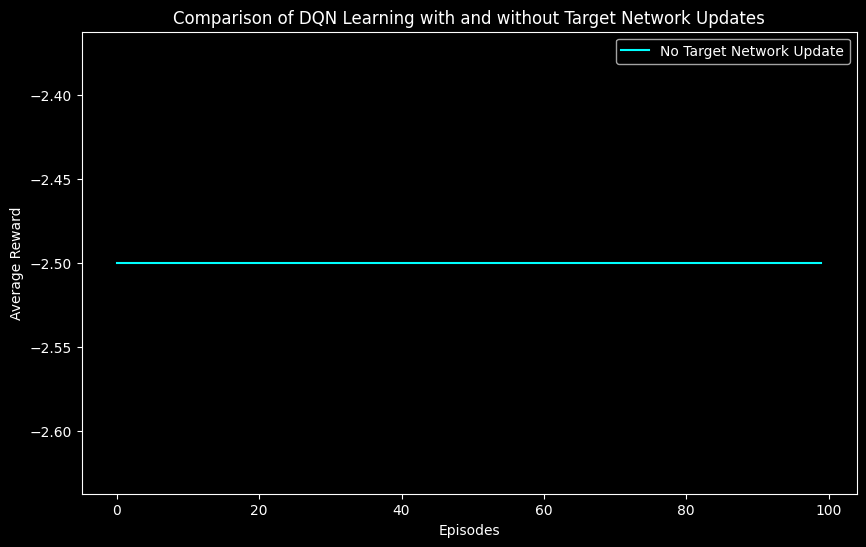

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate moving average for smoother visualization
def moving_average(data, window_size=100):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

plt.style.use('dark_background')
# Plotting
plt.figure(figsize=(10, 6))

# Plot for the model without target network updates
plt.plot(moving_average(all_scores_no_target_update), label='No Target Network Update', color='cyan')

# Plot for the model with target network updates
# plt.plot(moving_average(all_scores_with_target_update), label='With Target Network Update', color='orange')

# Add labels and title
plt.xlabel('Episodes', color='white')
plt.ylabel('Average Reward', color='white')
plt.title('Comparison of DQN Learning with and without Target Network Updates', color='white')
plt.legend()

# Change the color of the ticks and spines
plt.xticks(color='white')
plt.yticks(color='white')
plt.gca().spines['bottom'].set_color('white')
plt.gca().spines['left'].set_color('white')

# Show the plot
plt.show()


## Part 3 - Visualizing the results

#### implement the visualization of the results

In [11]:
import glob
import io
import base64
import imageio
from PIL import Image 
from IPython.display import HTML, display
import gymnasium as gym
from gymnasium.wrappers.monitoring.video_recorder import VideoRecorder

# Function to resize frames to be divisible by 16
def resize_frame(frame):
    img = Image.fromarray(frame)
    width, height = img.size
    
    # Adjust width and height to be divisible by 16
    new_width = (width + 15) // 16 * 16
    new_height = (height + 15) // 16 * 16
    
    # Resize only if needed
    if width != new_width or height != new_height:
        img = img.resize((new_width, new_height))
    
    return img

def show_video_of_model(agent, env_name, video_name):
    env = gym.make(env_name, render_mode='rgb_array', full_action_space = False, mode=0)
    state, _ = env.reset()
    done = False
    frames = []
    while not done:
        frame = env.render()
        # Resize frame to be divisible by 16 to support macro block size 16x16 oterwise warning will be shown
        resized_frame = resize_frame(frame)
        frames.append(resized_frame)
        action = agent.act(state)
        state, reward, done, _, _ = env.step(action.item())
    env.close()
    imageio.mimsave(video_name + '.mp4', frames, fps=30)
    return video_name + '.mp4'

# show_video_of_model(agent, 'LunarLander-v2', "video")

def show_video(video_name):
    mp4list = glob.glob(video_name)
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

# show_video()

#### load trained model

In [ ]:
trained_agent = Agent(state_size, number_actions)
trained_agent.local_qnetwork.load_state_dict(torch.load('checkpoint.pth', weights_only=True))

#### show agent video

In [39]:

video_name = show_video_of_model(agent, env_name, "tmp ep 800")
show_video(video_name)

/Users/harsh.rajput_awg/myspace/colab/venv/lib/python3.10/site-packages/gymnasium/envs/registration.py:513: DeprecationWarning: WARN: The environment MsPacmanDeterministic-v0 is out of date. You should consider upgrading to version `v4`.
  logger.deprecation(
/Users/harsh.rajput_awg/myspace/colab/venv/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:335: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(
